<a href="https://www.kaggle.com/code/kermercan/audio-project?scriptVersionId=241445016" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import shutil
import os
import numpy as np
import seaborn as sns
!pip install resampy
!pip install librosa
import librosa
from librosa.effects import pitch_shift as librosa_pitch_shift
from librosa.effects import time_stretch as librosa_time_stretch

import resampy
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, SeparableConv2D, LeakyReLU
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.0 MB/s eta 0:00:00


In [2]:
def create_model(input_shape, num_classes):
    model = Sequential([
        # First block - smaller filters, more feature maps
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),  # LeakyReLU instead of ReLU
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(), 
        LeakyReLU(alpha=0.1),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
        
        # Second block
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(), 
        LeakyReLU(alpha=0.1),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(), 
        LeakyReLU(alpha=0.1),
        MaxPooling2D((2, 2)),
        Dropout(0.15),
        
        # Third block - Separable convolutions for efficiency
        SeparableConv2D(128, (3, 3), padding='same'),
        BatchNormalization(), 
        LeakyReLU(alpha=0.1),
        SeparableConv2D(128, (3, 3), padding='same'),
        BatchNormalization(), 
        LeakyReLU(alpha=0.1),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Fourth block
        SeparableConv2D(256, (3, 3), padding='same'),
        BatchNormalization(), 
        LeakyReLU(alpha=0.1),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Global Average Pooling instead of Flatten (reduces overfitting)
        GlobalAveragePooling2D(),
        
        # Dense layers with L2 regularization
        Dense(256, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.4),
        
        Dense(64, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
        ])
    return model

# Parametreler
input_shape = [256, 256, 1]  # Giriş şekli (1 kanal - grayscale)
num_classes = 10
n_epochs = 100
batch_size = 64
learning_rate = 0.001
fixed_sample_rate = 44100
n_mels = 256
image_size = (256, 256)

# Verisetinin yolu
train_data_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Train/"
train_label_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Train.csv"

# CSV'yi oku
df_train = pd.read_csv(train_label_path)
df_train.head()

# Özellikler ve etiketler için boş listeler
feature = []
label = []

# Ses dosyalarını işleme
for i in tqdm(range(len(df_train))):
    file_name = train_data_path + df_train.iloc[i]["file_name"]
    y, sr = librosa.load(file_name, sr=fixed_sample_rate)
    
    # Mel-spektrogram oluştur
    mels = librosa.feature.melspectrogram(y=y, sr=fixed_sample_rate, n_mels=n_mels, fmax=fixed_sample_rate // 2)
    mels = librosa.amplitude_to_db(mels, ref=np.max)
    
    # Görselleştirme ve yeniden boyutlandırma
    im = Image.fromarray(np.uint8(mels / np.max(np.abs(mels)) * 255))
    im = im.resize(image_size, resample=Image.Resampling.LANCZOS)
    mels_resized = np.array(im) / 255.0  # Normalize (0-1)
    
    # Özellik ve etiket ekleme
    feature.append(mels_resized)
    label.append(df_train.iloc[i]["classID"])

# Özellikler ve etiketlerin numpy dizisine dönüştürülmesi
X = np.expand_dims(np.stack(feature, axis=0), axis=3)  # Kanal boyutu ekleme
Y = np.array(label)
Y = to_categorical(Y)

# Veri setini bölme
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=1)

# DÜZELTME 1: ImageDataGenerator konfigürasyonu
# Eğer önceden işlenmiş numpy array'leri kullanıyorsanız, rescale=1./255 kullanmayın
# Çünkü veriler zaten 0-1 arasında normalize edilmiş
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    # rescale=1./255 KALDIRILDI - veriler zaten normalize
)

# DÜZELTME 2: Eğer numpy array'leri kullanıyorsanız, flow_from_directory yerine flow kullanın
# Veya directory yapısı kullanıyorsanız, o zaman ImageDataGenerator'ı farklı şekilde yapılandırın

# SEÇENEK A: Numpy array'leri kullanmak (mevcut yaklaşımınız)
train_gen = train_datagen.flow(
    X_train, 
    Y_train,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Validation için augmentation yapmayın
val_datagen = ImageDataGenerator()  # rescale kaldırıldı
val_gen = val_datagen.flow(
    X_valid,
    Y_valid,
    batch_size=batch_size,
    shuffle=False
)

# Model parametreleri
model_name = "kerim"

# Sınıf ağırlıklarını hesapla
classes = np.unique(Y_train.argmax(axis=1))
class_weights = compute_class_weight('balanced', classes=classes, y=Y_train.argmax(axis=1))
class_weight_dict = {i: class_weights[i] for i in range(len(classes))}

# Model oluştur ve derle
model = create_model(input_shape, num_classes)
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbackler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint_cb = ModelCheckpoint(filepath=model_name + '_best.keras', monitor='val_loss', save_best_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=os.path.join("logs", model_name), histogram_freq=1)

callbacks = [lr_scheduler, early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# DÜZELTME 3: Model eğitimi - çakışan validation_data parametreleri düzeltildi
history = model.fit(
    train_gen,  # generator kullanın
    epochs=n_epochs,
    validation_data=val_gen,  # sadece bir validation_data
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)
# Modeli kaydet
model.save(model_name + '.keras')
print(f"Model {model_name}.keras olarak kaydedildi.")

100%|██████████| 7057/7057 [05:19<00:00, 22.10it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2452 - loss: 2.4301

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 2.83985, saving model to kerim_best.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 379ms/step - accuracy: 0.2459 - loss: 2.4277 - val_accuracy: 0.0411 - val_loss: 2.8398 - learning_rate: 0.0010
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4175 - loss: 1.8495
Epoch 2: val_loss did not improve from 2.83985
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.4177 - loss: 1.8491 - val_accuracy: 0.0411 - val_loss: 3.3794 - learning_rate: 0.0010
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.4852 - loss: 1.7017
Epoch 3: val_loss did not improve from 2.83985
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step - accuracy: 0.4855 - loss: 1.7008 - val_accuracy: 0.0411 - val_loss: 4.4699 - learning_rate: 0.0010
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5521 - loss: 1.4884
Epoch 4: val_loss did not improve from 2.83985
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - accuracy: 0.5522 - loss: 1.4880 - val_accuracy

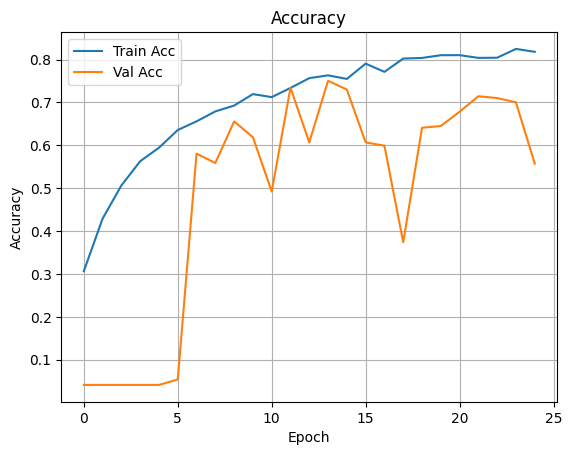

In [3]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy')
plt.show()


In [4]:
!pip install gdown
import gdown

# Test veri yolu ve etiketleri
test_data_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Test_Public/"
test_label_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Test_Public.csv"
df_test = pd.read_csv(test_label_path)

feature_test = []
label_test = []

for i in tqdm(range(len(df_test))):
    file_name = test_data_path + df_test.iloc[i]["file_name"]
    
    # Ses dosyasını yükle ve yeniden örnekle
    X, sr = librosa.load(file_name, sr=fixed_sample_rate)
    
    # Mel-spektrogram oluştur
    mels = librosa.feature.melspectrogram(y=X, sr=fixed_sample_rate, n_mels=n_mels, fmax=fixed_sample_rate // 2)
    mels = librosa.amplitude_to_db(mels, ref=np.max)  # Logaritmik skala
    
    # Görselleştirme ve yeniden boyutlandırma
    im = Image.fromarray(np.uint8(mels / np.max(np.abs(mels)) * 255))  # 0-255 ölçekleme
    im = im.resize(image_size, resample=Image.Resampling.LANCZOS)  # Daha iyi interpolasyon
    mels_resized = np.array(im) / 255.0  # Normalize (0-1)

    feature_test.append(mels_resized)
    label_test.append(df_test.iloc[i]["classID"])

# Özellikler ve etiketlerin numpy dizisine dönüştürülmesi
X_test = np.expand_dims(np.stack(feature_test, axis=0), axis=3)
Y_test = np.array(label_test)
Y_test = to_categorical(Y_test)

# Modeli yükleme
url = "https://drive.google.com/uc?export=download&id=18R4e01IEjA89ImCqQB-HifBgBU4CZs5z"
output = 'kerim.keras'
gdown.download(url, output, quiet=False)

model = tf.keras.models.load_model(output)

# Test verisi ile tahmin yapma
predictions = model.predict(X_test)

# Test seti değerlendirme
score_test = model.evaluate(X_test, Y_test)

print(f"Test Loss: {score_test[0]}")
print(f"Test Accuracy: {score_test[1]}")

100%|██████████| 82/82 [00:03<00:00, 23.11it/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=18R4e01IEjA89ImCqQB-HifBgBU4CZs5z
To: /kaggle/working/kerim.keras
100%|██████████| 4.41M/4.41M [00:00<00:00, 101MB/s]
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 84 variables whereas the saved optimizer has 88 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.6974 - loss: 0.8401
Test Loss: 0.8401026129722595
Test Accuracy: 0.707317054271698
